In [2]:
# n number of subsequences of a patient's notes
# c is scaling factor and controls influence of number of subsequences 
# use c= 2
# pmax is max probability of readmission
# pmean is mean probability of readmission
from datasets import load_dataset
import os
import numpy as np
import torch
from scipy.special import softmax
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
#tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

/home/ubuntu/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
def encode(examples):
     return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

In [4]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
model = DistilBertForSequenceClassification.from_pretrained("../../models/orig_lr4e-5/checkpoint-12000")

In [5]:
# training model on tokenized and split data
class Dataset(torch.utils.data.Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val) for key, val in self.inputs[idx].items() if key != 'text'}
        item['labels'] = torch.tensor(int(self.labels[idx]['text']))
        return item

    def __len__(self):
        return len(self.labels)

In [6]:
def probability(test_dataset):
    # generates prediction from model
    train_pred = trainer.predict(test_dataset)
    pred = train_pred.predictions
    
    # softmax each row so each row sums to 1
    prob = softmax(pred, axis = 1)
    
    # find the mean probability of readmission
    meanprob = np.mean(prob,axis=0)[1]
    
    # find the max probability of readmission
    maxprob = np.amax(prob,axis=0)[1]
    
    n = pred.shape[0]
    
    # return mean, max, shape
    return meanprob, maxprob, n

In [1]:
def prepare_data(patientID):
    # loading features and labels per patient
    input_dataset = load_dataset('text', data_files={'test': '../../data/update/concatenated/patients/'+patientID})
    label_dataset = load_dataset('text', data_files={'test': '../../data/update/concatenated/patients/labels/'+patientID})
    
    # applying encoding function to dataset
    input_dataset = input_dataset.map(encode, batched=True)
    
    # setting dataset to testing dataset
    test_dataset = Dataset(input_dataset['test'], label_dataset['test'])
    
    return test_dataset

In [8]:
# calculating readmit probability on per patient basis
def readmit_probability(maxprob,meanprob,n):
    # c accounts for patients with many notes
    c=2
    # weight as n/c
    scaling = n/c
    denominator = 1+scaling
    numerator = maxprob + (meanprob * scaling)
    
    probability = numerator/denominator
    return probability

In [327]:
#from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve, auc, RocCurveDisplay, average_precision_score
import sklearn.metrics
from sklearn.metrics import PrecisionRecallDisplay

# generating numpy array of all the real labels
def patient_labels(patients):
    labels = []
    for i in range(len(patients)):
        # taking label per patient
        with open('../../data/labels/'+ patients[i], 'r') as f:
            text = f.readline().strip()
            if text == '1':
                labels.append(1)
            elif text == '0':
                labels.append(0)
    
    label_array = np.asarray(labels)
            
    return label_array

# take in probabilities per patient array and threshold
# turn into list of labels of 0 or 1
def convert_probability(pred, threshold):
    labels= []
    for val in pred:
        if val>threshold:
            labels.append(1)
        else:
            labels.append(0)
            
    labels_array = np.asarray(labels)        
    return labels_array

# computing accuracy, f1, precision, recall, auroc
# parameters are the arrays of predicted labels, real labels, and predicted probabilities
def compute_metrics(pred_label, real_label, readmit_prob):
    labels = real_label
    preds = pred_label
    predictions = readmit_prob
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    roc = roc_auc_score(labels, predictions)
    fpr, tpr, thresholds = roc_curve(labels,predictions)
    roc_auc = auc(fpr, tpr)
    
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,)
    display.plot()
    prc = average_precision_score(labels, predictions)
    
    precision, recall, _ = precision_recall_curve(labels, predictions)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot() 
    return {
        'accuracy': acc,
        'f1': f1,
        #'precision': precision,
        #'recall': recall,
        'auroc': roc,
        'auroc_display' : display,
        'auprc': prc,
        #'auprc_display' : disp,
        'fpr': fpr,
        'tpr':tpr,
    }

def compute_tpr(pred_label, real_label, readmit_prob):
    labels = real_label
    preds = pred_label
    predictions = readmit_prob
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    roc = roc_auc_score(labels, predictions)
    fpr, tpr, thresholds = roc_curve(labels,predictions)
    
    return fpr, tpr

def compute_prc(pred_label, real_label, readmit_prob):
    labels = real_label
    preds = pred_label
    predictions = readmit_prob
    precision, recall, thresholds = precision_recall_curve(labels, predictions)
    
    return precision, recall

In [10]:
trainer = Trainer(
    # the instantiated 🤗 Transformers model to be trained
    model=model,
)

In [11]:
with open('../../data/splits/valid_list','r') as f:
    lines = f.read().splitlines()
    set_valid = set(lines)
valid_list = list(set_valid)

with open('../../data/splits/test_list','r') as f:
    lines = f.read().splitlines()
    set_test = set(lines)
test_list = list(set_test)

In [22]:
# takes in list of patients from either valid split or test split
# lists are valid_list or test_list
def evaluate(split):
    # empty list of scalable readmission prediction probabilities
    patient_prob = []
    
    # load valid list for testing
    for i in range(len(split)):
        # load the patient datset
        test_dataset = prepare_data(split[i])

        # find the max and mean probability of readmission
        mean, maximum, n = probability(test_dataset)

        # calculate readmission probability per patient
        readmit = readmit_probability(mean,maximum,n)

        # add probabilities into list of all patient probabilities
        patient_prob.append(readmit)
        print(i)
    
    return patient_prob

In [97]:
# generating patient probability from model
# pass in either valid_list or test_list
patient_prob = evaluate(valid_list[:15])

# generating actual labels of patients for valid list
# pass in either valid_list or test_list
real_labels = patient_labels(valid_list[:15])

# turn predicted probability list into 1d numpy array
pred_prob = np.asarray(patient_prob)

# generate label array from probability list and threshold
# if probability over a certain threshold, generate a readmit label of 1
# otherwise, readmit = 0
pred_labels = convert_probability(pred_prob,0.1)

print(real_labels)
print(pred_prob)
print(pred_labels)

Using custom data configuration default
Reusing dataset text (/home/ubuntu/.cache/huggingface/datasets/text/default-3e19ec7f7f2644f2/0.0.0/daf90a707a433ac193b369c8cc1772139bb6cca21a9c7fe83bdd16aad9b9b6ab)
Using custom data configuration default
Reusing dataset text (/home/ubuntu/.cache/huggingface/datasets/text/default-34f5df87db561b03/0.0.0/daf90a707a433ac193b369c8cc1772139bb6cca21a9c7fe83bdd16aad9b9b6ab)
Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/text/default-3e19ec7f7f2644f2/0.0.0/daf90a707a433ac193b369c8cc1772139bb6cca21a9c7fe83bdd16aad9b9b6ab/cache-19a967c3df8a5d42.arrow
Using custom data configuration default
Reusing dataset text (/home/ubuntu/.cache/huggingface/datasets/text/default-0bf049cc091870e0/0.0.0/daf90a707a433ac193b369c8cc1772139bb6cca21a9c7fe83bdd16aad9b9b6ab)


0


Using custom data configuration default
Reusing dataset text (/home/ubuntu/.cache/huggingface/datasets/text/default-a441e02143a1abca/0.0.0/daf90a707a433ac193b369c8cc1772139bb6cca21a9c7fe83bdd16aad9b9b6ab)
Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/text/default-0bf049cc091870e0/0.0.0/daf90a707a433ac193b369c8cc1772139bb6cca21a9c7fe83bdd16aad9b9b6ab/cache-616bbec74ed4ee7c.arrow
Using custom data configuration default
Reusing dataset text (/home/ubuntu/.cache/huggingface/datasets/text/default-23a84bc2cc97cf4b/0.0.0/daf90a707a433ac193b369c8cc1772139bb6cca21a9c7fe83bdd16aad9b9b6ab)
Using custom data configuration default


1


Reusing dataset text (/home/ubuntu/.cache/huggingface/datasets/text/default-acf0c736ef08f158/0.0.0/daf90a707a433ac193b369c8cc1772139bb6cca21a9c7fe83bdd16aad9b9b6ab)
Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/text/default-23a84bc2cc97cf4b/0.0.0/daf90a707a433ac193b369c8cc1772139bb6cca21a9c7fe83bdd16aad9b9b6ab/cache-ed2798692e7b3b2a.arrow
Using custom data configuration default
Reusing dataset text (/home/ubuntu/.cache/huggingface/datasets/text/default-66c402bcb3f582e6/0.0.0/daf90a707a433ac193b369c8cc1772139bb6cca21a9c7fe83bdd16aad9b9b6ab)
Using custom data configuration default
Reusing dataset text (/home/ubuntu/.cache/huggingface/datasets/text/default-e39417a9a212b3b6/0.0.0/daf90a707a433ac193b369c8cc1772139bb6cca21a9c7fe83bdd16aad9b9b6ab)


2


Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/text/default-66c402bcb3f582e6/0.0.0/daf90a707a433ac193b369c8cc1772139bb6cca21a9c7fe83bdd16aad9b9b6ab/cache-bcfa9de01cf3890b.arrow
Using custom data configuration default
Reusing dataset text (/home/ubuntu/.cache/huggingface/datasets/text/default-00a5a346a53920a8/0.0.0/daf90a707a433ac193b369c8cc1772139bb6cca21a9c7fe83bdd16aad9b9b6ab)
Using custom data configuration default
Reusing dataset text (/home/ubuntu/.cache/huggingface/datasets/text/default-7fb1e5d2e54bef16/0.0.0/daf90a707a433ac193b369c8cc1772139bb6cca21a9c7fe83bdd16aad9b9b6ab)
Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/text/default-00a5a346a53920a8/0.0.0/daf90a707a433ac193b369c8cc1772139bb6cca21a9c7fe83bdd16aad9b9b6ab/cache-50f7250a16eb7cba.arrow


3


KeyboardInterrupt: 

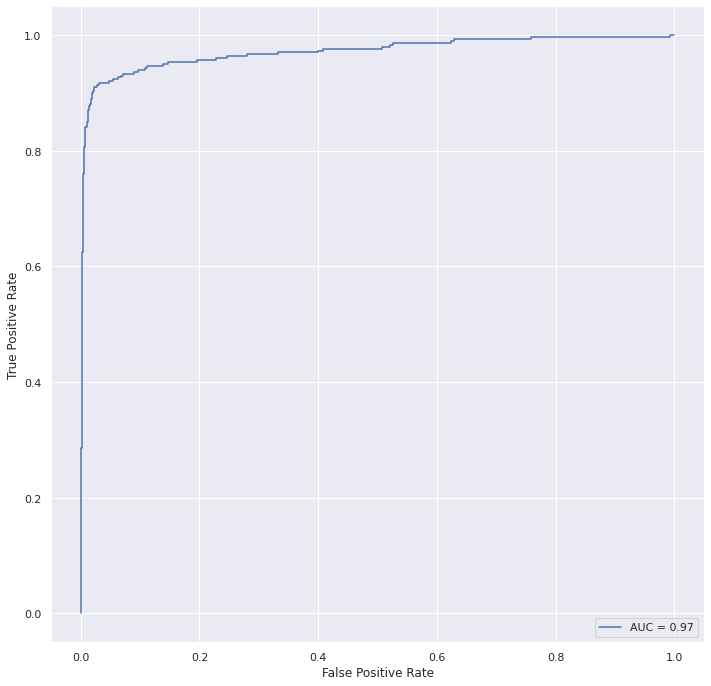

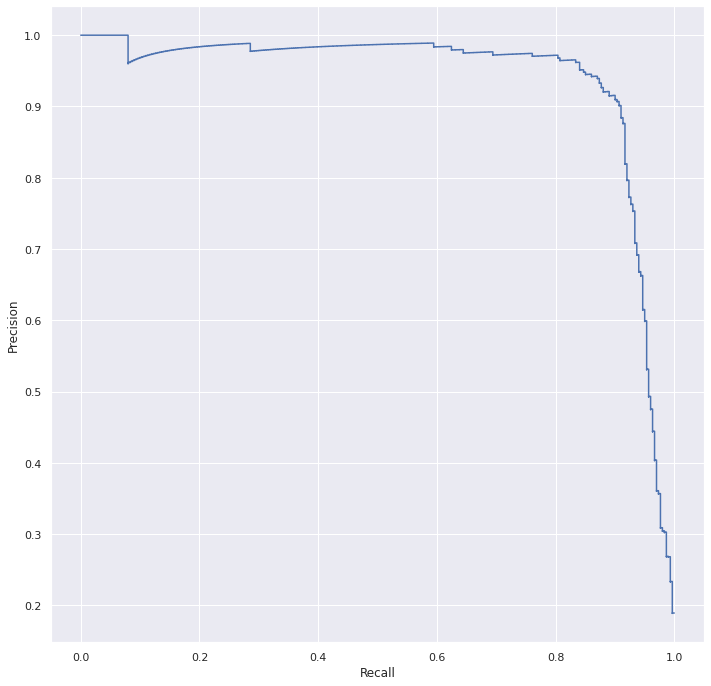

In [328]:
# computing the metrics 
compute_metrics(s2pred_labels, s2real_labels, s2pred_prob)
sfpr, stpr = compute_tpr(s2pred_labels, s2real_labels, s2pred_prob)
sprec, srec = compute_prc(s2pred_labels, s2real_labels, s2pred_prob)

array([0.188125 , 0.8681672, 1.       ])

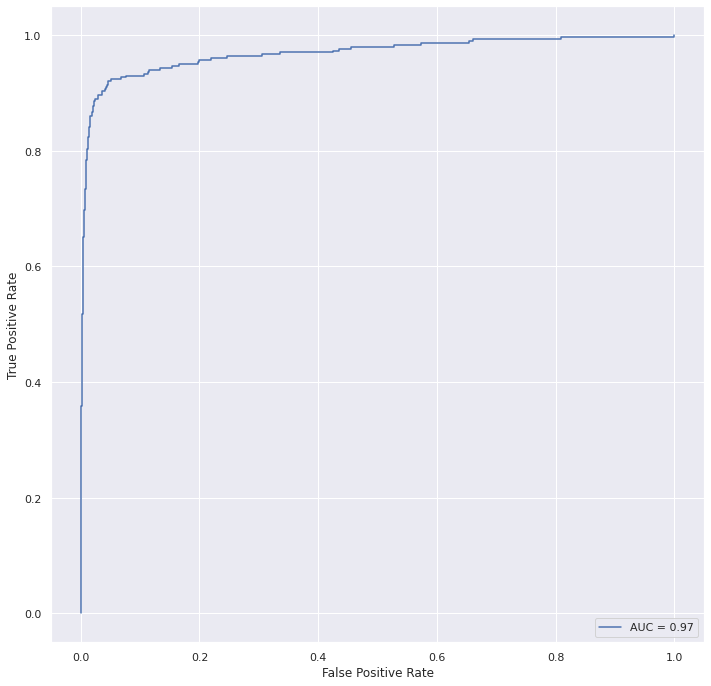

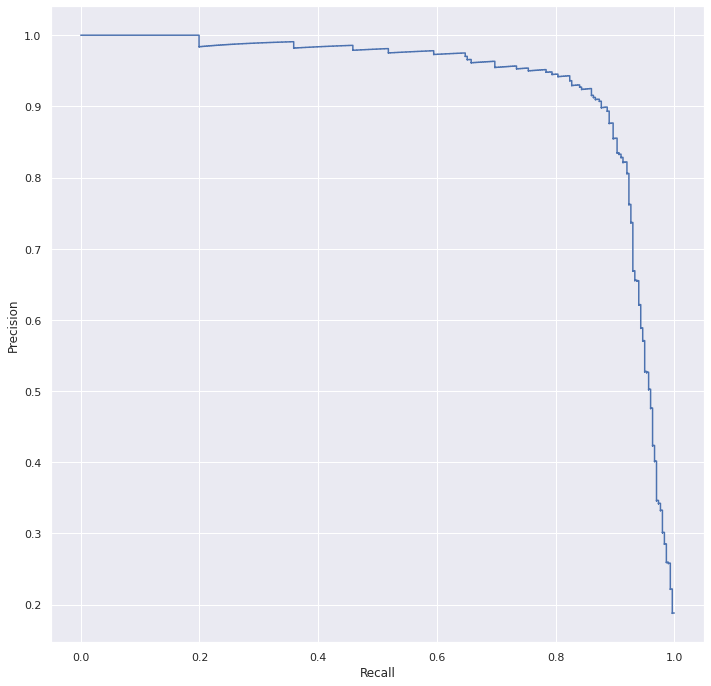

In [329]:
# computing the metrics 
compute_metrics(pred_labels, real_labels, pred_prob)
bfpr, btpr = compute_tpr(pred_labels, real_labels, pred_prob)
bprec, brec = compute_prc(pred_labels, real_labels, pred_prob)

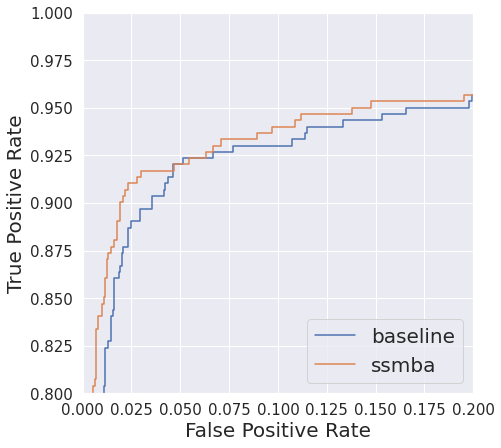

In [353]:
sns.set_style('whitegrid')
sns.despine()
sns.set(rc={'figure.figsize':(7,7)})
plt.plot(bfpr, btpr, label='baseline')
plt.plot(sfpr, stpr, label='ssmba')
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.xlabel("False Positive Rate", fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel("True Positive Rate", fontsize=20)
plt.yticks(fontsize=15)
plt.legend(loc=4, prop={'size': 20})
plt.show()

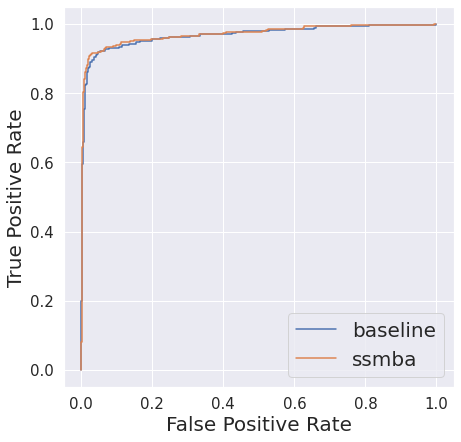

In [354]:
sns.set_style('white')
sns.set(rc={'figure.figsize':(7,7)})
plt.plot(bfpr, btpr, label='baseline')
plt.plot(sfpr, stpr, label='ssmba')
plt.xlabel("False Positive Rate", fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel("True Positive Rate", fontsize=20)
plt.yticks(fontsize=15)
plt.legend(loc=4, prop={'size': 20})
plt.show()

In [319]:
brec

0.8970099667774086

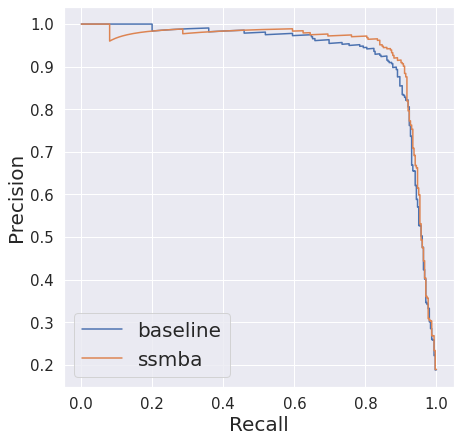

In [358]:
sns.set_style('white')
sns.set(rc={'figure.figsize':(7,7)})
plt.plot(brec, bprec, label='baseline')
plt.plot(srec, sprec, label='ssmba')
plt.xlabel("Recall", fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel("Precision", fontsize=20)
plt.yticks(fontsize=15)
plt.legend(loc=3, prop={'size': 20})
plt.show()

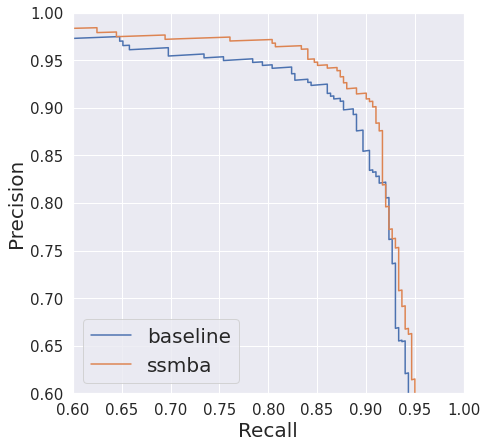

In [363]:
sns.set_style('white')
sns.set(rc={'figure.figsize':(7,7)})
plt.plot(brec, bprec, label='baseline')
plt.plot(srec, sprec, label='ssmba')
plt.xlim(0.6, 1)
plt.ylim(0.6, 1)
plt.xlabel("Recall", fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel("Precision", fontsize=20)
plt.yticks(fontsize=15)
plt.legend(loc=3, prop={'size': 20})
plt.show()

In [239]:
s1real_labels = np.load('../../models/ssmba_0.1/test/real_labels.npz')
s1pred_prob = np.load('../../models/ssmba_0.1/test/pred_prob.npz')
s1pred_labels = convert_probability(s1pred_prob, 0.85)

s2real_labels = np.load('../../models/ssmba_0.2/test/real_labels.npz')
s2pred_prob = np.load('../../models/ssmba_0.2/test/pred_prob.npz')
s2pred_labels = convert_probability(s2pred_prob, 0.75)

s3real_labels = np.load('../../models/ssmba_0.3/test/real_labels.npz')
s3pred_prob = np.load('../../models/ssmba_0.3/test/pred_prob.npz')
s3pred_labels = convert_probability(s3pred_prob, 0.85)

s4real_labels = np.load('../../models/ssmba_0.4/test/real_labels.npz')
s4pred_prob = np.load('../../models/ssmba_0.4/test/pred_prob.npz')
s4pred_labels = convert_probability(s4pred_prob, 0.85)

real_labels = np.load('../../models/orig_lr4e-5/test/real_labels.npz')
pred_prob = np.load('../../models/orig_lr4e-5/test/pred_prob.npz')
pred_labels = convert_probability(pred_prob, 0.55)

In [233]:
test = 0.0
threshold = 0.05
optimize = 0.0
while threshold < 1.0:
    pred_labels = convert_probability(pred_prob, threshold)
    precision, recall, f1, _ = precision_recall_fscore_support(real_labels, pred_labels, average='binary')
    if f1 > test:
        test = f1
        optimize = threshold
    threshold += 0.05
print(optimize)

0.5499999999999999


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [195]:
# load the patient datset
test1_dataset = prepare_data(valid_list[10])

# find the max and mean probability of readmission
mean1, maximum1, n1 = probability(test1_dataset)

# calculate readmission probability per patient
readmit1 = readmit_probability(mean1,maximum1,n1)


Using custom data configuration default
Reusing dataset text (/home/ubuntu/.cache/huggingface/datasets/text/default-a1ba682b66c55cb5/0.0.0/daf90a707a433ac193b369c8cc1772139bb6cca21a9c7fe83bdd16aad9b9b6ab)
Using custom data configuration default
Reusing dataset text (/home/ubuntu/.cache/huggingface/datasets/text/default-bf9a0a18d9225359/0.0.0/daf90a707a433ac193b369c8cc1772139bb6cca21a9c7fe83bdd16aad9b9b6ab)
Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/text/default-a1ba682b66c55cb5/0.0.0/daf90a707a433ac193b369c8cc1772139bb6cca21a9c7fe83bdd16aad9b9b6ab/cache-c52975535d677fb8.arrow


In [196]:
print(n1)

7


In [199]:
len(test_list)

1600

In [205]:
cntr = 0
for i in test_labels:
    if i == 1:
        cntr += 1

cntr

301

In [204]:
test_labels = patient_labels(test_list)